# We use the data from the Tononi Serial Awakenings from MONASH University

The task is to run `EMD` on one of these EEG signals and compare different tunings of the algorithm:
 - Using at least two different splines: `Natural` and `Hermite`
 - Using different stoppage criteria: `sifting number=10` and run until the default version stops

On every IMF we will run `FFT` and copmute the `IF` with HT (or Kalman)

This process will be repeated with added noise and offset.

In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mne
mne.set_log_level('error')  # suppress mne warnings
from scipy.signal import stft
import pywt


In [30]:
def generate_sinusoidal_signal(frequency=4, duration=3, sampling_rate=1000):
    """
    Generate a sinusoidal signal.

    Args:
        frequency (float): Frequency of the sine wave in Hz.
        duration (float): Duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Sinusoidal signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.sin(2 * np.pi * frequency * t)
    return t, signal

def generate_windowed_sinusoidal(frequency=12, duration=3, sampling_rate=1000, start=1, end=2):
    """
    Generate a sinusoidal signal with given frequency between 'start' and 'end' seconds, zero elsewhere.

    Args:
        frequency (float): Frequency of the sine wave in Hz.
        duration (float): Total duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.
        start (float): Start time of the sinusoidal part in seconds.
        end (float): End time of the sinusoidal part in seconds.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Windowed sinusoidal signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.zeros_like(t)
    mask = (t >= start) & (t < end)
    signal[mask] = np.sin(2 * np.pi * frequency * t[mask])
    return t, signal

def generate_chirp_signal(f0=30, f1=0, duration=3, sampling_rate=1000):
    """
    Generate a linear chirp signal.

    Args:
        f0 (float): Starting frequency of the chirp in Hz.
        f1 (float): Ending frequency of the chirp in Hz.
        duration (float): Duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Chirp signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    k = (f1 - f0) / duration  # Chirp rate
    signal = np.sin(2 * np.pi * (f0 * t + 0.5 * k * t**2))
    return signal

# Read the EEG data

In [154]:
# Load the data [.edf file]

root_dir = "C:\\Users\\oddar\\OneDrive - NTNU\\Documents\\Universitet\\Adaptive Data Analysis\\Group Work\\Real data"
data_dir = "Tononi Serial Awakenings Part 2\\Data\\PSG"
import os

file_dir = os.path.join(root_dir, data_dir, "s01_ep06.edf") 
data_raw = mne.io.read_raw_edf(file_dir, preload=True, misc=["Chan 257"])  # Load the EDF file


# Set the montage to the data, aka. the physical locations of the electrodes
montage_dir = "Tononi Serial Awakenings-Part1-No_PSGs\\Tononi Serial Awakenings\\Data\\HydroCelGSN256v10.sfp"
montage = mne.channels.read_custom_montage(os.path.join(root_dir, montage_dir))
""" # Rename channel 1 to Status
montage.rename_channels({'1': 'Status'}) """
# Rename channels from "1", "2", ... to "Chan 1", "Chan 2", ...
montage.rename_channels(lambda x: f"Chan {int(x)}" if x.isdigit() else x)
# montage.rename_channels(lambda x: "Chan 257" if x == "Cz" else x) # Rename channel "Cz" to "Chan 257"
data_raw.set_montage(montage)  # Set custom montage

print(data_raw)
print(data_raw.info)  # Print info about the data

<RawEDF | s01_ep06.edf, 258 x 60000 (120.0 s), ~118.4 MiB, data loaded>
<Info | 9 non-empty values
 bads: []
 ch_names: Chan 1, Chan 2, Chan 3, Chan 4, Chan 5, Chan 6, Chan 7, Chan 8, ...
 chs: 256 EEG, 1 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2022-11-07 19:24:44 UTC
 nchan: 258
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: 1, sex: 1, first_name: 1, last_name: 6>
>


# Preprocessing
Add bad channels to the bads list

In [164]:
# Find channels with values above 0.001
high_value_channels = data_raw.get_data() > 0.001

# Find channels with values below -0.001
low_value_channels = data_raw.get_data() < -0.001

# Return a list of channel names with values below -0.001 at any time point
channels_below_neg_0_001 = [data_raw.ch_names[i] for i in range(low_value_channels.shape[0]) if np.any(low_value_channels[i])]
print(channels_below_neg_0_001)  # Print the channel names with values below -0.001
# Return a list of channel names with values above 0.001 at any time point
channels_above_0_001 = [data_raw.ch_names[i] for i in range(high_value_channels.shape[0]) if np.any(high_value_channels[i])]
print(channels_above_0_001)  # Print the channel names with values above 0.001

# Find and print the channels with values constant between three or more consecutive time points
constant_value_channels = []
for i in range(data_raw.get_data().shape[0]):
    channel_data = data_raw.get_data()[i]
    diffs = np.diff(channel_data)
    constant_indices = np.where(diffs == 0)[0]
    if len(constant_indices) > 0:
        # Check for three or more consecutive indices
        consec_count = 1
        for j in range(1, len(constant_indices)):
            if constant_indices[j] == constant_indices[j-1] + 1:
                consec_count += 1
                if consec_count >= 5:  # We need at least two diffs to have three constant points
                    constant_value_channels.append(data_raw.ch_names[i])
                    break
            else:
                consec_count = 1
print(constant_value_channels)  # Print the channel names with constant values

# Add all these channels to the bads list
data_raw.info['bads'].extend(channels_below_neg_0_001)
data_raw.info['bads'].extend(channels_above_0_001)
data_raw.info['bads'].extend(constant_value_channels)

# Create a copy of the data excluding the bad channels, excluding status
bad_channels = channels_below_neg_0_001 + channels_above_0_001 + constant_value_channels
bad_channels = list(set(bad_channels))  # Remove duplicates
if 'Status' in bad_channels:
    bad_channels.remove('Status')
print("Bad channels:", bad_channels)
data = data_raw.copy().drop_channels(bad_channels)


['Chan 142']
['Chan 142', 'Status']
['Chan 81', 'Chan 232', 'Chan 237', 'Chan 244', 'Chan 257', 'Status']
Bad channels: ['Chan 237', 'Chan 244', 'Chan 142', 'Chan 232', 'Chan 257', 'Chan 81']


In [145]:
trans = mne.channels.compute_native_head_t(montage)  # Compute the transformation matrix
print(trans)

<Transform | unknown->head>
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


C:\Users\oddar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


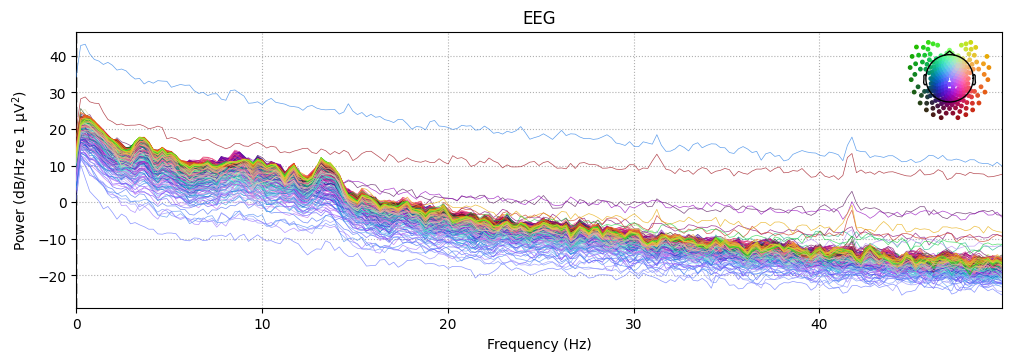

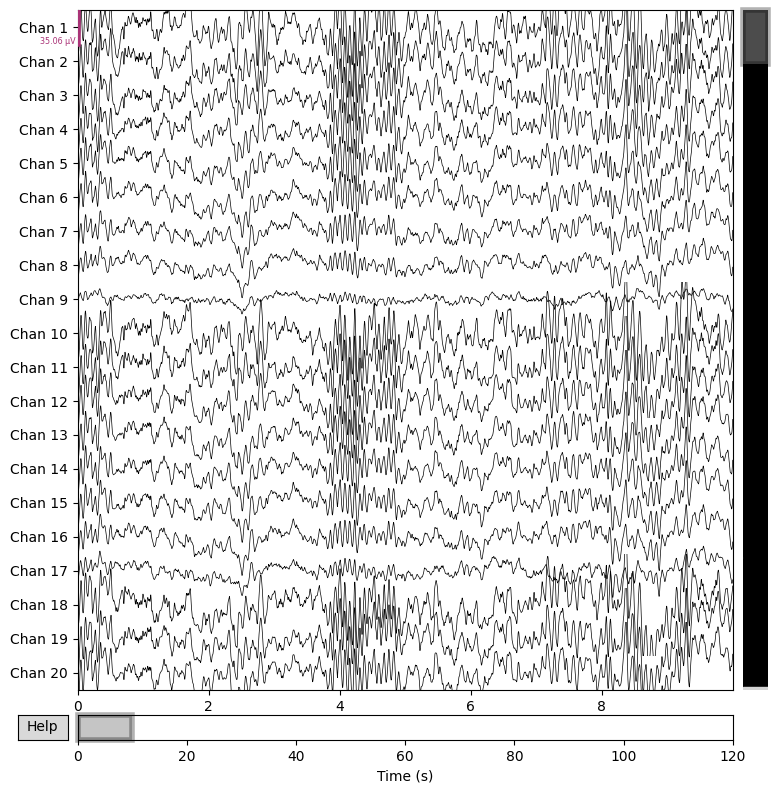

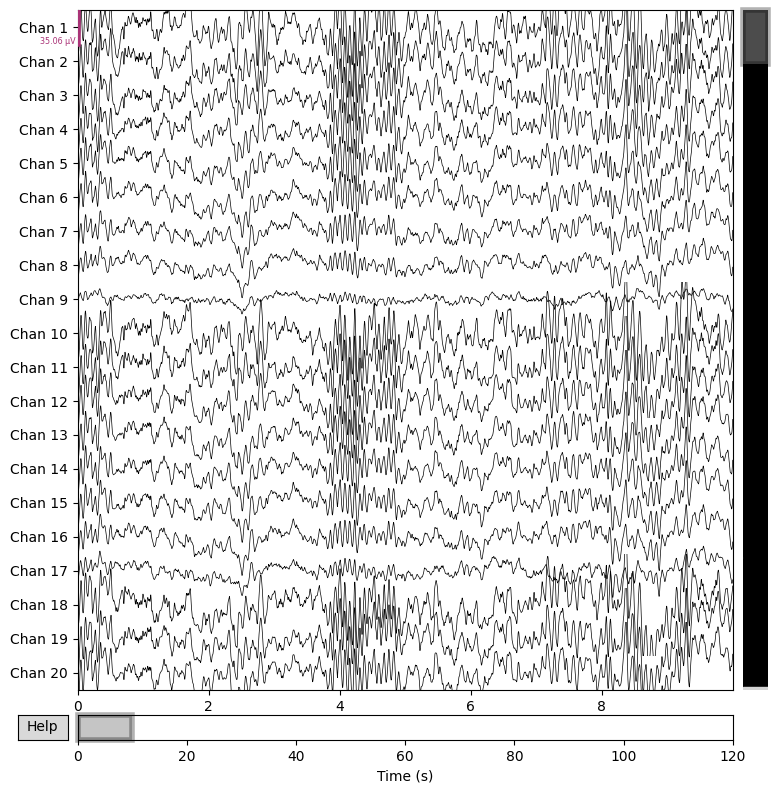

In [166]:
data.compute_psd(fmax=50).plot(picks='data', amplitude=False)  # Plot the power spectral density (PSD) of the data
data.plot(scalings='auto')  # Plot the raw data with automatic scaling

In [167]:
events = mne.find_events(data, stim_channel='Status')  # Find events in the data based on the 'Status' channel
print(events)  # Print the events

[]


In [168]:
annotations = data.annotations
print(annotations)  # Print annotations

<Annotations | 0 segments>


C:\Users\oddar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


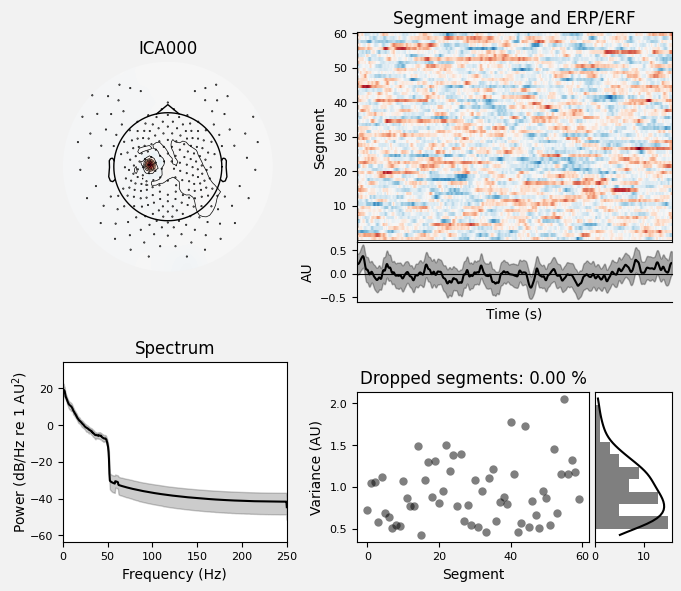

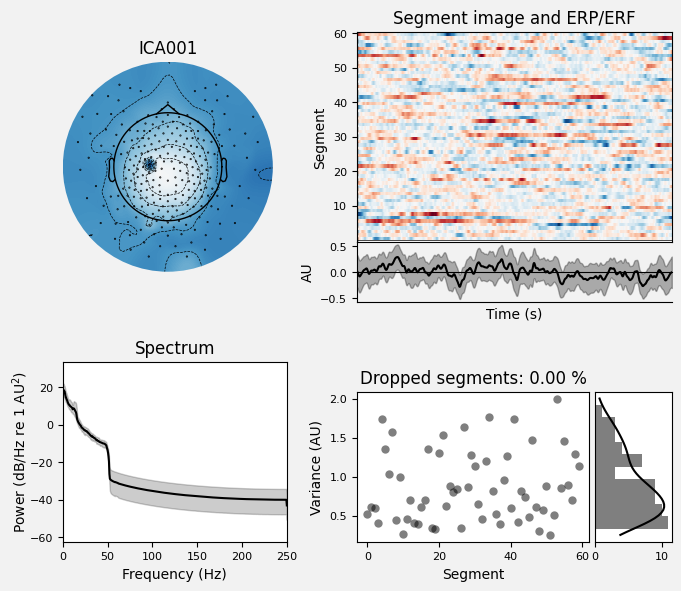

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [169]:
ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)
ica.fit(data)
ica.exclude = [0, 1]  # Exclude the first two components (for example)
ica.plot_properties(data, picks=ica.exclude)  # Plot properties of the first ICA component

Plotting original


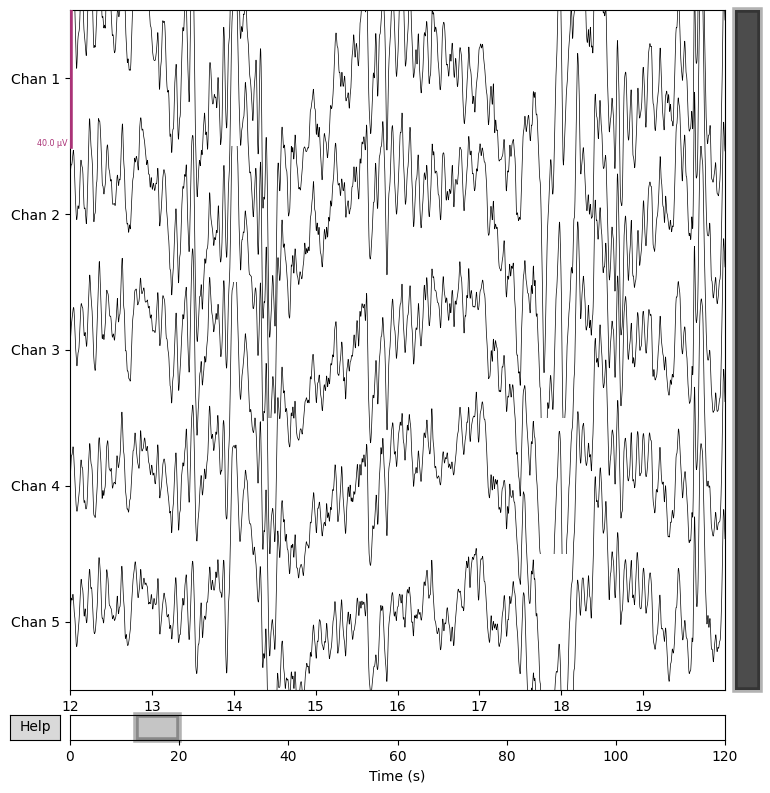

Plotting ICA cleaned


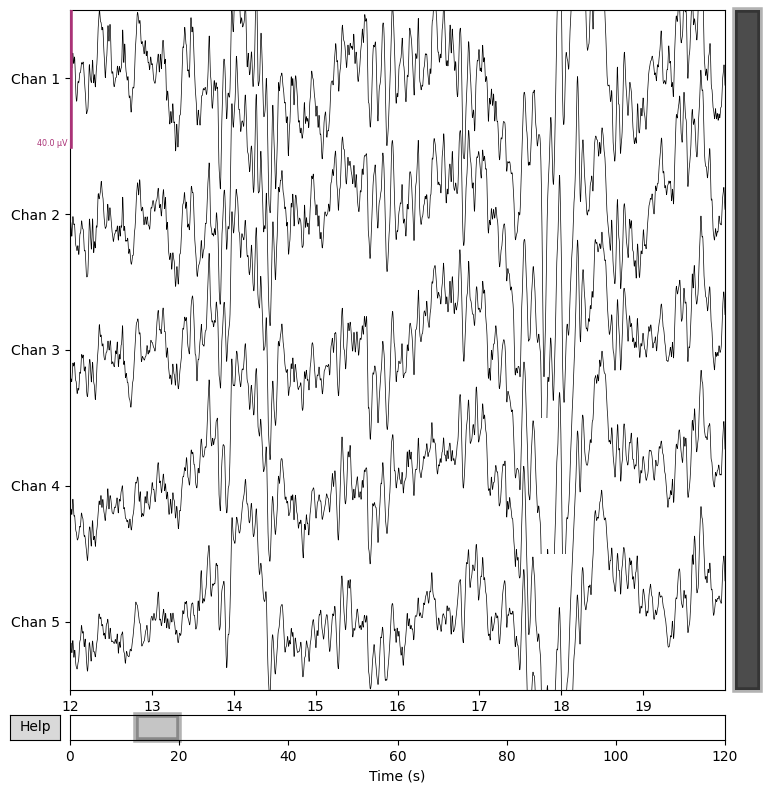

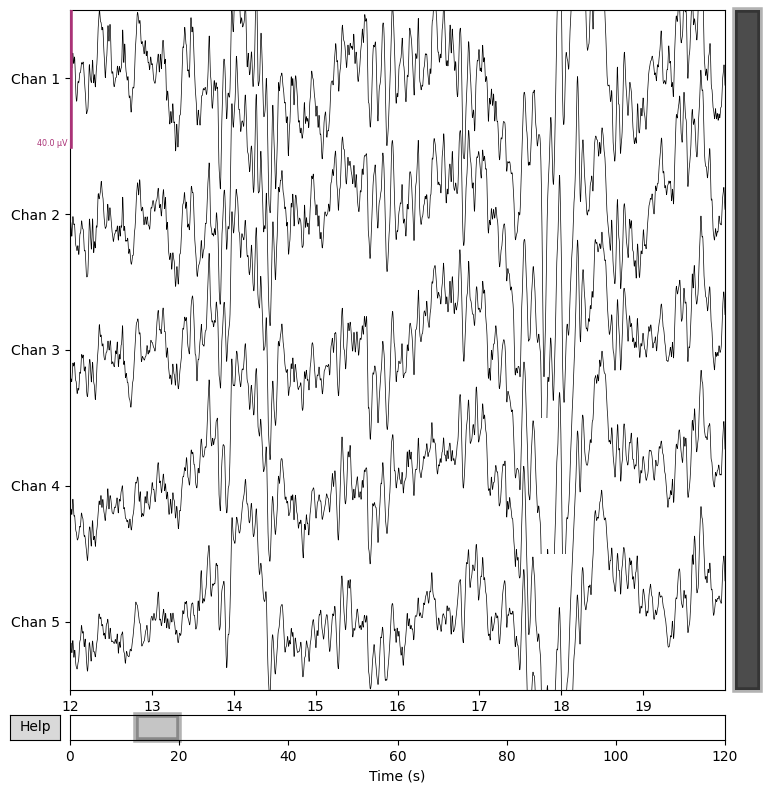

In [170]:
chs = [
    "Chan 1",
    "Chan 2",
    "Chan 3",
    "Chan 4",
    "Chan 5",
]
orig_raw = data.copy()
data.load_data()
ica.apply(data)  # Apply ICA to the data

chan_idx = [data.ch_names.index(ch) for ch in chs]
print("Plotting original")
orig_raw.plot(order=chan_idx, title='Original Data', start = 12, duration = 8)
print("Plotting ICA cleaned")
data.plot(order=chan_idx, title='ICA Cleaned Data', start = 12, duration = 8)

